In [1]:
import torch
import matplotlib
import sklearn
import moviepy

In [2]:
import pandas as pd
import numpy as np

# Cargar el dataset original
df = pd.read_csv("/Users/lucia/.cache/kagglehub/datasets/trisha2094/weatheraus/versions/1/weatherAUS.csv")

# Convertir 'RainTomorrow' a numérico
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})

# Calcular la matriz de correlación
corr_matrix = df.corr()

# Encontrar pares de columnas con correlación alta (>0.9 o <-0.9)
high_corr = corr_matrix.abs().unstack().sort_values(ascending=False)

# Filtrar solo pares altamente correlacionados (sin incluir la diagonal)
high_corr = high_corr[high_corr < 1.0]  # Excluir la autocorrelación (1.0)
high_corr = high_corr[high_corr > 0.9]  # Solo mostrar valores altos

print("🔍 Features con correlación muy alta (>0.9):")
print(high_corr)


🔍 Features con correlación muy alta (>0.9):
Temp3pm      MaxTemp        0.984562
MaxTemp      Temp3pm        0.984562
Pressure9am  Pressure3pm    0.961348
Pressure3pm  Pressure9am    0.961348
Temp9am      MinTemp        0.901813
MinTemp      Temp9am        0.901813
dtype: float64


In [4]:
import torch
from kan import *
import matplotlib.pyplot as plt
import moviepy.video.io.ImageSequenceClip

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cpu


In [5]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

def load_weather_dataset(file_path):
    # Load dataset
    df = pd.read_csv(file_path)

    # Drop 'RISK_MM' column (data leakage)
    df.drop(['RISK_MM'], axis=1, inplace=True)

    # Convert 'Date' to datetime and extract year, month, day
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day

    # Drop original 'Date' column
    df.drop('Date', axis=1, inplace=True)

    # 🔹 Remove highly correlated features
    df.drop(['Temp3pm', 'Pressure9am', 'Temp9am'], axis=1, inplace=True)

    # 🔹 Handle 'RainToday' & 'RainTomorrow'
    df['RainToday'].fillna('No', inplace=True)  
    df['RainTomorrow'].fillna('No', inplace=True)  # Assume 'No' if missing

    df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1}).astype(int)
    df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1}).astype(int)  # Target variable

    # Identify numerical and categorical columns
    num_cols = df.select_dtypes(include=['number']).columns.tolist()
    cat_cols = df.select_dtypes(exclude=['number']).columns.tolist()

    # Ensure 'RainTomorrow' is NOT treated as a feature
    num_cols.remove('RainTomorrow') if 'RainTomorrow' in num_cols else None
    cat_cols.remove('RainTomorrow') if 'RainTomorrow' in cat_cols else None

    # 🔹 Fill missing values (AFTER processing 'RainToday' & 'RainTomorrow')
    for col in num_cols:
        df[col].fillna(df[col].mean(), inplace=True)  # Replace missing numerical values with mean

    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)  # Replace missing categorical values with most frequent category

    # Encode categorical features
    label_encoders = {}
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le  # Store encoders for inverse transformation

    # Select feature columns (all except the target)
    feature_columns = num_cols + cat_cols  # Use only numerical and encoded categorical features
    target_column = 'RainTomorrow'  # Binary classification target

    # Extract data and target
    data = df[feature_columns].values
    target = df[target_column].values

    # 🔹 Apply MinMaxScaler to scale numerical features to range [-1, 1]
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data = scaler.fit_transform(data)

    # Convert to PyTorch tensors
    data_tensor = torch.tensor(data, dtype=torch.float32)
    target_tensor = torch.tensor(target, dtype=torch.long)

    # Split into train and test sets
    train_data, test_data, train_target, test_target = train_test_split(
        data_tensor, target_tensor, test_size=0.2, random_state=42
    )

    # Create PyTorch dataloaders
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(train_data, train_target), batch_size=1, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(test_data, test_target), batch_size=1, shuffle=False
    )

    # Create empty tensors
    train_inputs = torch.empty(0, len(feature_columns), device=device)
    train_labels = torch.empty(0, dtype=torch.long, device=device)
    test_inputs = torch.empty(0, len(feature_columns), device=device)
    test_labels = torch.empty(0, dtype=torch.long, device=device)

    # Concatenate all data into a single tensor on the specified device
    for data, labels in train_loader:
        train_inputs = torch.cat((train_inputs, data.to(device)), dim=0)
        train_labels = torch.cat((train_labels, labels.to(device)), dim=0)

    for data, labels in test_loader:
        test_inputs = torch.cat((test_inputs, data.to(device)), dim=0)
        test_labels = torch.cat((test_labels, labels.to(device)), dim=0)

    # Return dataset, feature names, label encoders, and scaler
    dataset = {
        'train_input': train_inputs,
        'test_input': test_inputs,
        'train_label': train_labels,
        'test_label': test_labels
    }

    return dataset, feature_columns, label_encoders, scaler  # Returning feature names

# Load dataset and extract feature names dynamically
weather_dataset, feature_names, label_encoders, scaler = load_weather_dataset(
    '/Users/lucia/.cache/kagglehub/datasets/trisha2094/weatheraus/versions/1/weatherAUS.csv'
)



In [6]:

print("Train data shape: {}".format(weather_dataset['train_input'].shape))
print("Train target shape: {}".format(weather_dataset['train_label'].shape))
print("Test data shape: {}".format(weather_dataset['test_input'].shape))
print("Test target shape: {}".format(weather_dataset['test_label'].shape))
print("====================================")

Train data shape: torch.Size([113754, 21])
Train target shape: torch.Size([113754])
Test data shape: torch.Size([28439, 21])
Test target shape: torch.Size([28439])


In [7]:
def print_example_data_point(dataset, feature_names):
    # Get a single data point from the dataset
    example_data_point = dataset['train_input'][0]

    # Get the corresponding target for the example data point
    example_target = int(dataset['train_label'][0])

    # Map numerical target to actual string label
    target_names = ['No', 'Yes']  # Adjust if necessary
    actual_label = target_names[example_target]

    # Print column names and their corresponding values
    print("\nExample Data Point:")
    for i, column_name in enumerate(feature_names):
        print(f"{column_name}: {example_data_point[i].item()}")  # Convert tensor to float

    # Print the target value and the actual string label
    print(f"\nTarget (numerical): {example_target}")
    print(f"Actual Label: {actual_label}")

# Print an example data point from weather dataset
print_example_data_point(weather_dataset, feature_names)



Example Data Point:
MinTemp: 0.19811320304870605
MaxTemp: 0.1833648383617401
Rainfall: -1.0
Evaporation: -0.924554169178009
Sunshine: 0.05170387774705887
WindGustSpeed: -0.47311174869537354
WindSpeed9am: -1.0
WindSpeed3pm: -0.7471264600753784
Humidity9am: 0.46000000834465027
Humidity3pm: 0.07999999821186066
Pressure3pm: 0.22106251120567322
Cloud9am: 0.1111111119389534
Cloud3pm: -0.3333333432674408
RainToday: -1.0
Year: -0.20000000298023224
Month: -0.8181818127632141
Day: -0.46666666865348816
Location: 0.0
WindGustDir: 0.7333333492279053
WindDir9am: -0.6000000238418579
WindDir3pm: 0.20000000298023224

Target (numerical): 1
Actual Label: Yes


MODEL

In [8]:
# Define the folder where images will be saved (if visualization is enabled)
image_folder = 'video_img'

# Define the KAN model with adjusted input and output sizes
model = KAN(width=[24, 10, 5, 2], grid=5, k=3, seed=0, device=device)  # Adjusted width for more features

# Forward pass on training data
model(weather_dataset['train_input'])

# Plot the model structure
model.plot(beta=100, scale=1, 
           in_vars=feature_names,  # Use extracted feature names dynamically
           out_vars=['No Rain', 'Rain'])  # Binary classification labels


checkpoint directory created: ./model
saving model version 0.0


IndexError: index 21 is out of bounds for dimension 0 with size 21

In [7]:
print("Unique values in train_label:", torch.unique(weather_dataset['train_label']))


Unique values in train_label: tensor([0, 1])


In [8]:
def train_acc():
    return torch.mean((torch.argmax(model(weather_dataset['train_input']), dim=1) == weather_dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(weather_dataset['test_input']), dim=1) == weather_dataset['test_label']).float())

results = model.fit(weather_dataset, opt="Adam", metrics=(train_acc, test_acc),
                      loss_fn=torch.nn.CrossEntropyLoss(), steps=8, lamb=0.01, lamb_entropy=10., save_fig=True, img_folder=image_folder)

| train_loss: 1.15e+00 | test_loss: 7.36e-01 | reg: 8.00e+02 | : 100%|█| 8/8 [05:41<00:00, 42.65s/it


saving model version 0.1


In [9]:
results['train_acc'][-1], results['test_acc'][-1]

(0.775515615940094, 0.7770315408706665)

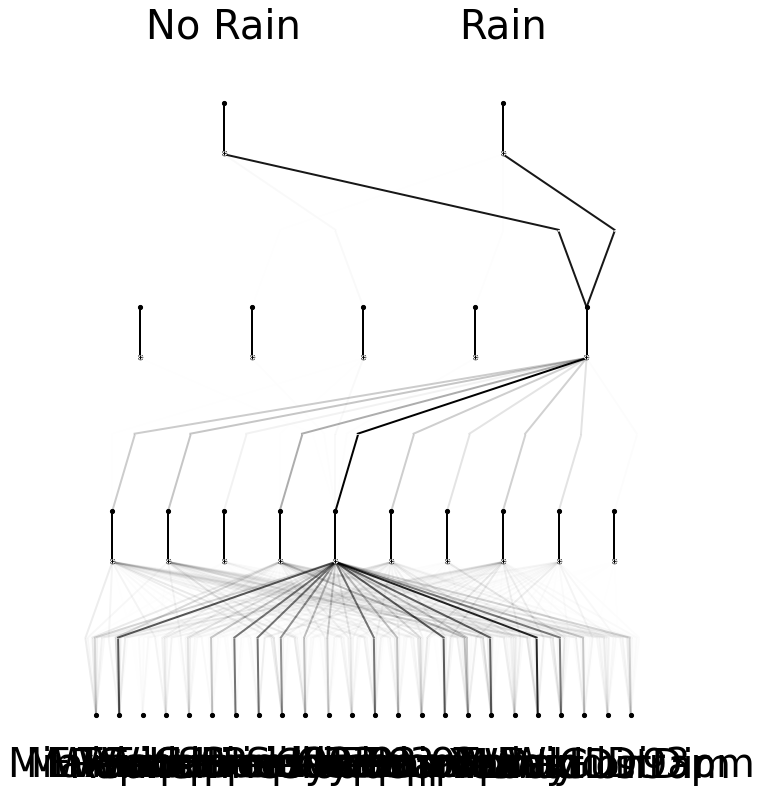

In [10]:
# Dynamically use the feature names from the dataset
model.plot(
    scale=1, 
    in_vars=feature_names,  # Use extracted feature names dynamically
    out_vars=['No Rain', 'Rain']  # Binary classification for RainToday
)


In [11]:
video_name='video'
fps=10

fps = fps
files = os.listdir(image_folder)
train_index = []
for file in files:
    if file[0].isdigit() and file.endswith('.jpg'):
        train_index.append(int(file[:-4]))

train_index = np.sort(train_index)

image_files = [image_folder+'/'+str(train_index[index])+'.jpg' for index in train_index]

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(video_name+'.mp4')

Moviepy - Building video video.mp4.
Moviepy - Writing video video.mp4



Moviepy - Done !
Moviepy - video ready video.mp4


saving model version 0.2


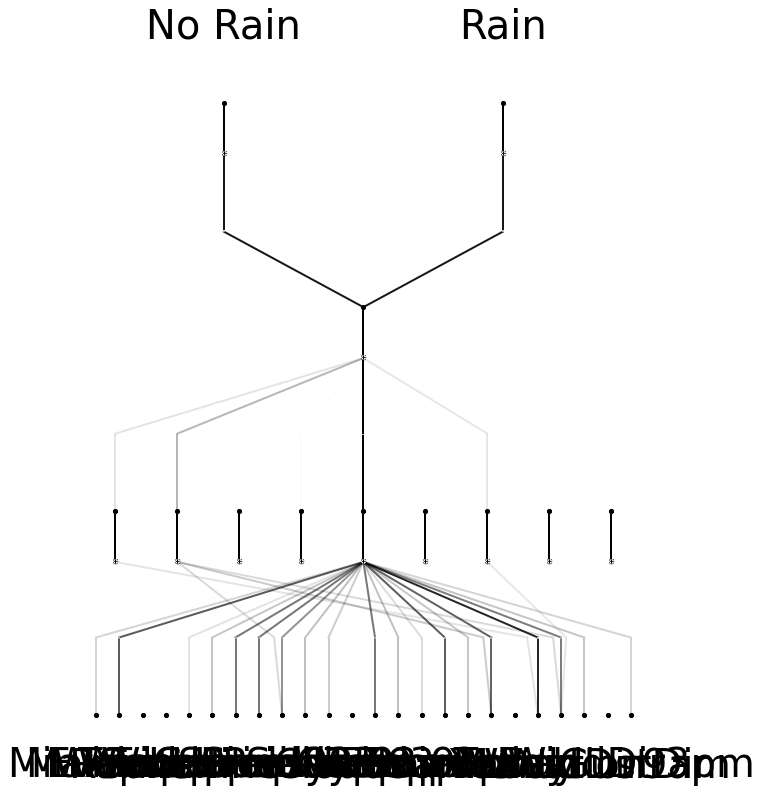

In [12]:
# Prune the model
model = model.prune()

# Run the pruned model on the weather dataset
model(weather_dataset['train_input'])

# Plot using dynamic feature names and correct output labels
model.plot(
    scale=1, 
    in_vars=feature_names,  # Use extracted feature names dynamically
    out_vars=['No Rain', 'Rain']  # Binary classification output
)


In [13]:
output = model(weather_dataset['train_input'])
print("Model output min:", output.min().item())
print("Model output max:", output.max().item())
print("NaN in model output:", torch.isnan(output).any())


Model output min: -2.1555771827697754
Model output max: 0.421284019947052
NaN in model output: tensor(False)


In [16]:
results_1 = model.fit(
    weather_dataset, 
    opt="Adam", 
    metrics=(train_acc, test_acc),
    loss_fn=torch.nn.CrossEntropyLoss(), 
    steps=10,  # Try a few more steps now
    lamb=0.01, 
    lamb_entropy=1.0,  # Keep entropy regularization low
    lr=0.00001  # Keep learning rate low for stability
)



description:   0%|                                                           | 0/10 [00:00<?, ?it/s]


Intel MKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel MKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel MKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel MKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel MKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel MKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel MKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel MKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel MKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel MKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel MKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel MKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel MKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel MKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel MKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel MKL ERROR: Parameter 6 was incorr

description:   0%|                                                           | 0/10 [00:06<?, ?it/s]

lstsq failed


UnboundLocalError: local variable 'coef' referenced before assignment